In [ ]:
# Cell 1: Imports
import os
import glob
import tempfile
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn as nn
import random
from monai.transforms import (
    Compose, LoadImageD, AddChannelD, EnsureTyped, SpacingD, OrientationD, ScaleIntensityRangeD,
    RandSpatialCropD, RandFlipD, RandRotate90D, EnsureType, RandGaussianNoiseD
)
from monai.data import Dataset, DataLoader, CacheDataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.visualize import matshow3d
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:
# Cell 2: Configuration & helper functions
DATA_ROOT = "./data"   # change to where your images/masks folders are
IM_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR = os.path.join(DATA_ROOT, "masks")
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Desired spacing used in paper for training IIS baseline
TARGET_SPACING = (2.0, 0.6, 0.6)  # (z, y, x) mm

def load_mha(path):
    itk = sitk.ReadImage(str(path))
    arr = sitk.GetArrayFromImage(itk)  # shape: (z,y,x)
    spacing = itk.GetSpacing()        # (x,y,z) in SimpleITK, careful
    direction = itk.GetDirection()
    origin = itk.GetOrigin()
    return arr, spacing, origin, direction

def write_mha(arr, reference_itk, out_path):
    # arr: numpy (z,y,x)
    out = sitk.GetImageFromArray(arr.astype(np.float32))
    out.SetSpacing(reference_itk.GetSpacing())
    out.SetOrigin(reference_itk.GetOrigin())
    out.SetDirection(reference_itk.GetDirection())
    sitk.WriteImage(out, str(out_path))

def resample_image(itk_image, target_spacing=TARGET_SPACING, is_label=False):
    # itk_image: SimpleITK Image
    # target_spacing: (z, y, x) mm
    # note: SimpleITK uses spacing (x,y,z)
    orig_spacing = itk_image.GetSpacing()  # (x,y,z)
    orig_size = itk_image.GetSize()        # (x,y,z)
    # Build new spacing in SimpleITK order
    new_spacing = (target_spacing[2], target_spacing[1], target_spacing[0])
    new_size = [
        int(np.round(orig_size[i] * (orig_spacing[i] / new_spacing[i]))) for i in range(3)
    ]
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(itk_image.GetDirection())
    resampler.SetOutputOrigin(itk_image.GetOrigin())
    if is_label:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resampler.SetInterpolator(sitk.sitkBSpline)
    res = resampler.Execute(itk_image)
    return res

def sitk_read_and_resample(path, target_spacing=TARGET_SPACING, is_label=False):
    itk = sitk.ReadImage(str(path))
    resampled = resample_image(itk, target_spacing=target_spacing, is_label=is_label)
    arr = sitk.GetArrayFromImage(resampled).astype(np.float32)  # (z,y,x)
    return arr, resampled  # return arr and itk image object for metadata


In [7]:
# Cell 3: Build dataset list
# Expect identical filenames in images/ and masks/ (mha format)
image_paths = sorted(glob.glob(os.path.join(IM_DIR, "*.mha")))
mask_paths = [os.path.join(MASK_DIR, os.path.basename(p)) for p in image_paths]
# keep only pairs where mask exists
pairs = [(i,m) for i,m in zip(image_paths, mask_paths) if os.path.exists(m)]
print(f"Found {len(pairs)} image-mask pairs")

# If dataset small, you can split
random.seed(42)
random.shuffle(pairs)
n_total = len(pairs)
n_val = max(1, int(0.15 * n_total))
train_pairs = pairs[n_val:]
val_pairs = pairs[:n_val]
print("Train:", len(train_pairs), "Val:", len(val_pairs))

Found 447 image-mask pairs
Train: 380 Val: 67


In [8]:
# Cell 4: Preprocess & create in-memory cache for MONAI (resample & save as npz temp files)
# This step can be slow first time; cache results for faster experiments.
tmp_cache_dir = "./spider_cache_updated"
os.makedirs(tmp_cache_dir, exist_ok=True)

def prepare_case(img_path, mask_path, out_base):
    # read and resample
    img_arr, img_itk = sitk_read_and_resample(img_path, target_spacing=TARGET_SPACING, is_label=False)
    mask_arr, _ = sitk_read_and_resample(mask_path, target_spacing=TARGET_SPACING, is_label=True)
    # normalize intensity per-volume: clip and scale (robust)
    p1, p99 = np.percentile(img_arr, (1,99))
    img_arr = np.clip(img_arr, p1, p99)
    img_arr = (img_arr - img_arr.mean()) / (img_arr.std() + 1e-8)
    # ensure shapes align
    assert img_arr.shape == mask_arr.shape, f"Shape mismatch {img_path}"
    np.savez_compressed(out_base + ".npz", image=img_arr.astype(np.float32), mask=mask_arr.astype(np.uint8))

# Prepare training cached npz files
train_list = []
for i, m in train_pairs:
    base = os.path.join(tmp_cache_dir, Path(i).stem + "_train")
    if not os.path.exists(base + ".npz"):
        prepare_case(i, m, base)
        print("preparing: ", base)
    train_list.append({"image": base + ".npz", "mask": base + ".npz"})

val_list = []
for i, m in val_pairs:
    base = os.path.join(tmp_cache_dir, Path(i).stem + "_val")
    if not os.path.exists(base + ".npz"):
        prepare_case(i, m, base)
        print("preparing: ", base)
    val_list.append({"image": base + ".npz", "mask": base + ".npz"})

print("Prepared cached npz for train/val")

preparing:  ./spider_cache_updated\58_t2_train
preparing:  ./spider_cache_updated\200_t1_train
preparing:  ./spider_cache_updated\51_t2_train
preparing:  ./spider_cache_updated\182_t1_train
preparing:  ./spider_cache_updated\152_t2_SPACE_train
preparing:  ./spider_cache_updated\138_t1_train
preparing:  ./spider_cache_updated\221_t1_train
preparing:  ./spider_cache_updated\171_t1_train
preparing:  ./spider_cache_updated\55_t2_SPACE_train
preparing:  ./spider_cache_updated\227_t1_train
preparing:  ./spider_cache_updated\48_t2_train
preparing:  ./spider_cache_updated\52_t2_SPACE_train
preparing:  ./spider_cache_updated\93_t2_train
preparing:  ./spider_cache_updated\250_t1_train
preparing:  ./spider_cache_updated\221_t2_train
preparing:  ./spider_cache_updated\34_t1_train
preparing:  ./spider_cache_updated\220_t1_train
preparing:  ./spider_cache_updated\137_t2_train
preparing:  ./spider_cache_updated\185_t2_train
preparing:  ./spider_cache_updated\252_t2_train
preparing:  ./spider_cache_up

In [9]:
import os
from pathlib import Path

# use local working dir instead of system temp
tmp_cache_dir = "./spider_cache_updated"
os.makedirs(tmp_cache_dir, exist_ok=True)

# get all cached npz files
all_files = list(Path(tmp_cache_dir).glob("*.npz"))
print("Found cached files:", len(all_files))

train_list, val_list = [], []

for f in all_files:
    fname = f.stem  # e.g., "100_train" or "101_val"
    if "_train" in fname:
        train_list.append({"npz": str(f)})
    elif "_val" in fname:
        val_list.append({"npz": str(f)})

print(f"Found {len(train_list)} training cases and {len(val_list)} validation cases.")


Found cached files: 447
Found 380 training cases and 67 validation cases.


In [10]:
valid_train, valid_val = [], []

for item in train_list:
    try:
        np.load(item['npz'])
        valid_train.append(item)
    except:
        print("Corrupt:", item['npz'])

for item in val_list:
    try:
        np.load(item['npz'])
        valid_val.append(item)
    except:
        print("Corrupt:", item['npz'])


In [ ]:
# =============================
# Cell 7: Dataset with correct label mapping
# =============================
class NPZDataset(Dataset):
    def __init__(self, items):
        super().__init__(data=items, transform=None)
        self.items = items

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        d = np.load(self.items[idx]['npz'])
        image = d['image'].astype(np.float32)
        mask  = d['mask'].astype(np.uint16)

        # --- Correct remapping ---
        ch_vertebra = ((mask >= 1) & (mask <= 8)).astype(np.uint8)
        ch_disc     = ((mask >= 201) & (mask <= 208)).astype(np.uint8)
        ch_canal    = (mask == 100).astype(np.uint8)

        multi_mask = np.stack([ch_vertebra, ch_disc, ch_canal], axis=0).astype(np.float32)
        image = image[np.newaxis,...].astype(np.float32)

        return {"image": image, "mask": multi_mask}

def collate_fn(batch):
    images = torch.from_numpy(np.stack([b['image'] for b in batch])).float()
    masks  = torch.from_numpy(np.stack([b['mask'] for b in batch])).float()
    return {"image": images, "mask": masks}

# Now using only 120 images for training
train_loader = DataLoader(NPZDataset(valid_train[:120]), batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(NPZDataset(valid_val[:30]),   batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)


In [ ]:

# =============================
# Cell 8: Model & training setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = 3
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(16,32,64,128,256),
    strides=(2,2,2,2),
    num_res_units=2,
).to(device)

dice_loss = DiceLoss(sigmoid=True, include_background=False)
bce_loss  = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    return 0.7 * dice_loss(pred, target) + 0.3 * bce_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# AMP for memory efficiency
from torch.amp import autocast, GradScaler
scaler = GradScaler("cuda")

Device: cuda


In [13]:
import torch.nn.functional as F

def pad_to_multiple_pair(img, mask, multiple=16):
    d, h, w = img.shape[-3:]
    pad_d = (multiple - d % multiple) % multiple
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    pad_args = (0, pad_w, 0, pad_h, 0, pad_d)  # (w_left, w_right, h_left, h_right, d_left, d_right)
    img = F.pad(img, pad_args)
    mask = F.pad(mask, pad_args)
    return img, mask

In [ ]:
# =============================
# Cell 9: Training loop
# =============================
n_epochs = 30
best_val_dice = 0.0
ROI_SIZE   = (64, 128, 128)   # patch size, divisible by 16
OVERLAP    = 0.25
save_path = os.path.join(OUTPUT_DIR, "best_model6.pth")

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs} train"):
        images, masks = batch['image'].to(device), batch['mask'].to(device)
        images, masks = pad_to_multiple_pair(images, masks)
        
        optimizer.zero_grad()
        with autocast("cuda"):
            outputs = model(images)
            loss = combined_loss(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss, dices = 0.0, []
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            images, masks = pad_to_multiple_pair(images, masks)
            outputs = model(images)
            vloss = combined_loss(outputs, masks).item()
            val_loss += vloss

            probs = torch.sigmoid(outputs)
            pred = (probs > 0.5).float()

            per_class_d = []
            for c in range(num_classes):
                inter = (pred[:,c]*masks[:,c]).sum()
                union = pred[:,c].sum() + masks[:,c].sum()
                per_class_d.append((2*inter/union).item() if union>0 else 1.0)
            dices.append(per_class_d)

    val_loss /= len(val_loader)
    mean_dice = np.mean(np.array(dices), axis=0)
    print(f"Epoch {epoch} train_loss {train_loss:.4f} val_loss {val_loss:.4f} Dice {mean_dice}")

    scheduler.step(val_loss)
    if mean_dice.mean() > best_val_dice:
        best_val_dice = mean_dice.mean()
        torch.save(model.state_dict(), save_path)
        print("Saved best model.")

print("Training finished. Best val dice:", best_val_dice)


Epoch 1/2 train: 100%|██████████| 120/120 [04:01<00:00,  2.02s/it]


Epoch 1 train_loss 0.8646 val_loss 0.8168 Dice [0.05755227 0.07610541 0.03157126]
Saved best model.


Epoch 2/2 train: 100%|██████████| 120/120 [05:26<00:00,  2.72s/it]


Epoch 2 train_loss 0.7776 val_loss 0.7419 Dice [0.31763993 0.22320637 0.22343323]
Saved best model.
Training finished. Best val dice: 0.254759842902422


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


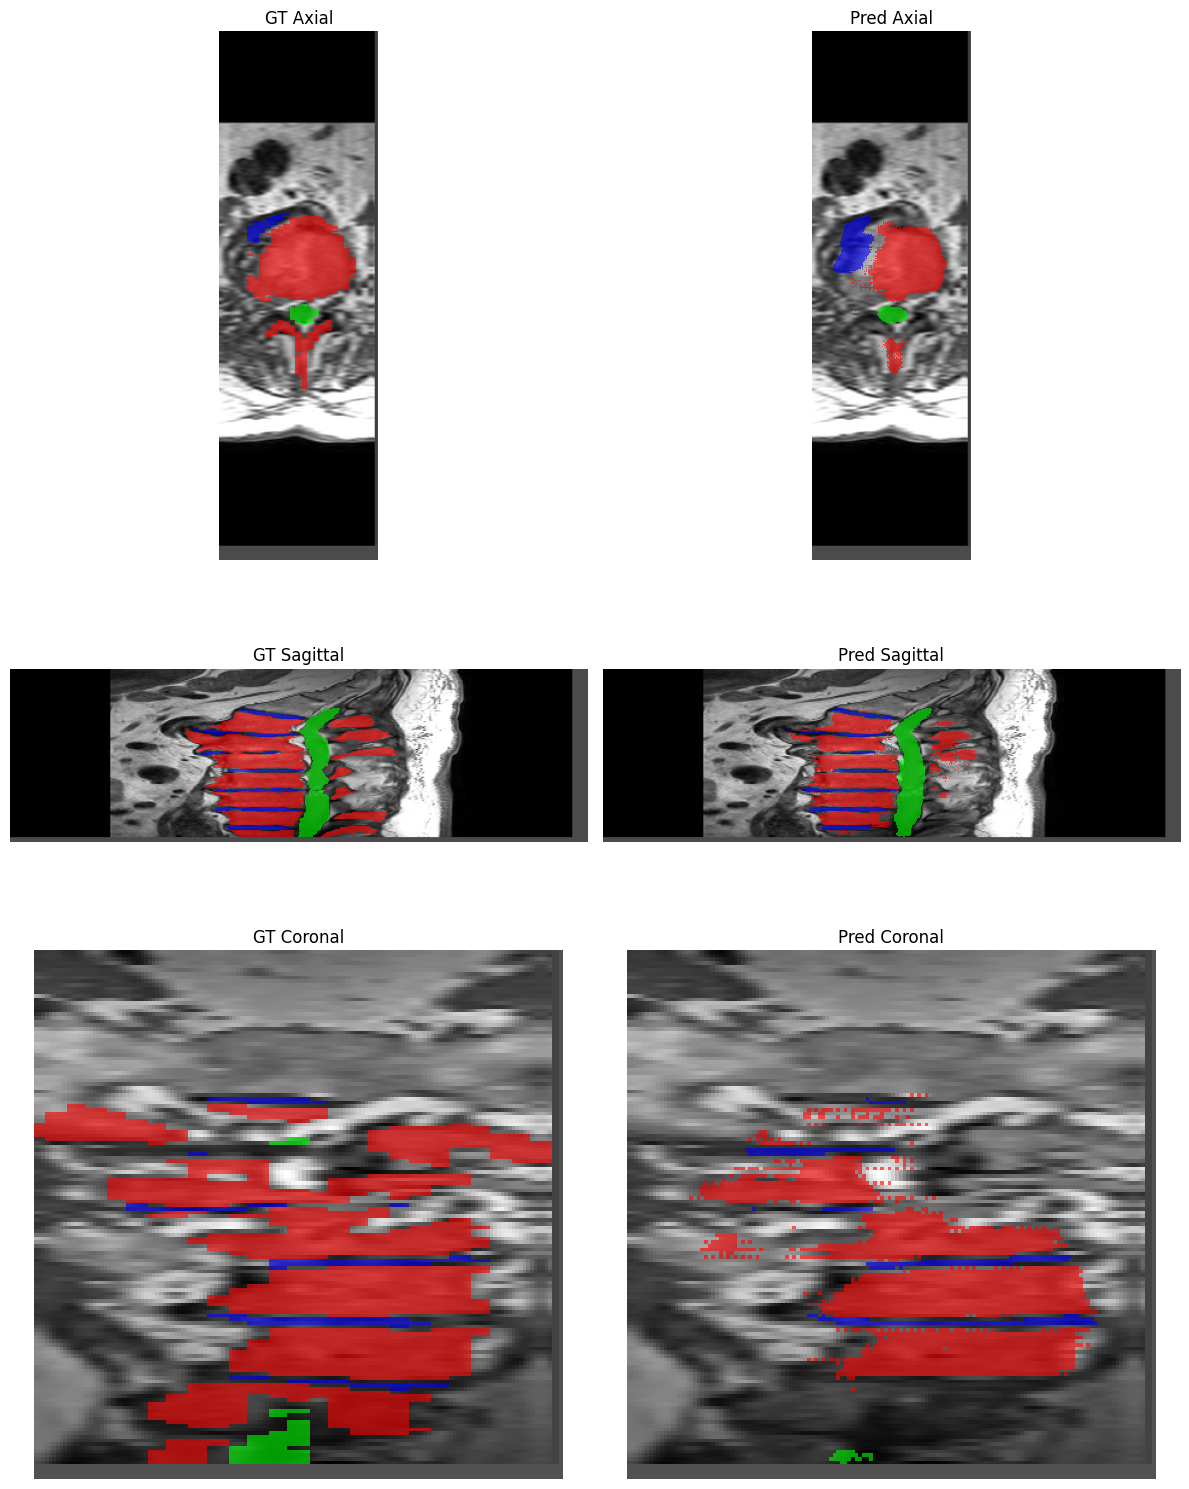

In [19]:
# =============================
# Cell X: Inference & Visualization
# =============================

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- Paths (change here if needed) ---
model_path = os.path.join(OUTPUT_DIR, "best_model5.pth")   # trained model
case_path  = "spider_cache_updated/251_t1_train.npz"  # example case

# --- Load model ---
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Load case ---
d = np.load(case_path)
image = d["image"].astype(np.float32)[None,None]   # (1,1,Z,Y,X)
mask  = d["mask"].astype(np.uint8)[None]           # (1,C,Z,Y,X)
image_t = torch.from_numpy(image).to(device)
mask_t  = torch.from_numpy(mask).to(device)

# Pad to multiple of 16
image_t, mask_t = pad_to_multiple_pair(image_t, mask_t)

# --- Inference ---
with torch.no_grad():
    with autocast("cuda"):
        logits = model(image_t)
        probs  = torch.sigmoid(logits)
        pred   = (probs > 0.5).float()

# --- Convert to numpy ---
img_np   = image_t[0,0].cpu().numpy()      # (Z,Y,X)
mask_np  = mask_t[0].cpu().numpy()         # (C,Z,Y,X)
pred_np  = pred[0].cpu().numpy()           # (C,Z,Y,X)

# --- GT: derive from labelmap (Z,Y,X) ---
gt_seg = mask_np  # integer labelmap
gt_vertebra = ((gt_seg >= 1) & (gt_seg <= 8)).astype(np.uint8)
gt_disc     = ((gt_seg >= 201) & (gt_seg <= 208)).astype(np.uint8)
gt_canal    = (gt_seg == 100).astype(np.uint8)

# --- Pred: already 3 channels (C,Z,Y,X) ---
pr_vertebra, pr_disc, pr_canal = pred_np

# --- Pick slice indices ---
z_mid = img_np.shape[0] // 2
y_mid = img_np.shape[1] // 2
x_mid = img_np.shape[2] // 2

def show_overlay(ax, img, vertebra, disc, canal, title):
    ax.imshow(img, cmap="gray")

    # Force color maps with strong visible colors
    red_cmap   = ListedColormap([[0,0,0,0], [1,0,0,0.6]])   # transparent, red
    blue_cmap  = ListedColormap([[0,0,0,0], [0,0,1,0.6]])   # transparent, blue
    green_cmap = ListedColormap([[0,0,0,0], [0,1,0,0.6]])   # transparent, green

    ax.imshow(vertebra, cmap=red_cmap)
    ax.imshow(disc, cmap=blue_cmap)
    ax.imshow(canal, cmap=green_cmap)

    ax.set_title(title)
    ax.axis("off")

# --- Plot ---
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Axial
show_overlay(axs[0,0], img_np[z_mid,:,:], gt_vertebra[z_mid,:,:], gt_disc[z_mid,:,:], gt_canal[z_mid,:,:], "GT Axial")
show_overlay(axs[0,1], img_np[z_mid,:,:], pr_vertebra[z_mid,:,:], pr_disc[z_mid,:,:], pr_canal[z_mid,:,:], "Pred Axial")

# Sagittal
show_overlay(axs[1,0], img_np[:,:,x_mid], gt_vertebra[:,:,x_mid], gt_disc[:,:,x_mid], gt_canal[:,:,x_mid], "GT Sagittal")
show_overlay(axs[1,1], img_np[:,:,x_mid], pr_vertebra[:,:,x_mid], pr_disc[:,:,x_mid], pr_canal[:,:,x_mid], "Pred Sagittal")

# Coronal
show_overlay(axs[2,0], img_np[:,y_mid,:], gt_vertebra[:,y_mid,:], gt_disc[:,y_mid,:], gt_canal[:,y_mid,:], "GT Coronal")
show_overlay(axs[2,1], img_np[:,y_mid,:], pr_vertebra[:,y_mid,:], pr_disc[:,y_mid,:], pr_canal[:,y_mid,:], "Pred Coronal")

plt.tight_layout()
plt.show()
